In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import pickle
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from dataloader.builder import build_dataset
from model.mlp import MLP
from uncertainty_estimator.masks import build_masks 
from experiment_setup import build_estimator
from analysis.metrics import get_uq_metrics
from experiments.utils.data import scale, split_ood, multiple_kfold

plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import torch
from loss.nll_loss import NLLRegLoss
from torch.nn import functional as F
from model.ensemble import MLPEnsemble

def nll_postprocessing(x):
    return torch.cat([x[:, [0]], F.softplus(x[:, [1]])], dim=1)

def nll_mean_only(x):
    return x[:, 0]

In [8]:
config = {
    'nn_runs': 100,
    'runs': 2,
    'max_runs': 20,
    'k_folds': 10,
    'verbose': False,
    'layers': [8, 256, 256, 128, 1],
    'nll_layers': [8, 256, 256, 128, 2],
    'epochs': 10_000,
    'validation_step': 100,
    'acc_percentile': 0.1,
    'patience': 3,
    'dropout_train': 0.2,
    'dropout_uq': 0.5,
    'batch_size': 256,
    'dataset': 'energy_efficiency',
    'l2_reg': 1e-5,
    'ood_percentile': 90,
}


In [13]:
# Get data
dataset = build_dataset(config['dataset'], val_split=0.01) 
x_all, y_all = dataset.dataset('train')
x_set, y_set, x_ood, y_ood = split_ood(x_all, y_all, config['ood_percentile'])
config['layers'][0] = x_all.shape[-1]
config['nll_layers'][0] = x_all.shape[-1]


In [14]:
masks = build_masks(nn_runs=config['nn_runs'])

In [15]:
# Evaluate different masks
def evaluate_masks(model, masks, x_val, y_val, y_scaler, tag='standard'):
    predictions = model(x_val).cpu().numpy()
    errors = np.abs(predictions - y_val)
    scaled_errors = y_scaler.inverse_transform(predictions) - y_scaler.inverse_transform(y_val)
    rmse = np.sqrt(np.mean(np.square(scaled_errors)))
    results = []

    for name, mask in masks.items():
        estimator = build_estimator(
            'mcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])

        for run in range(config['runs']):
            estimations = estimator.estimate(x_val)
            acc, ndcg, ll = get_uq_metrics(estimations, errors, config['acc_percentile'])
            results.append([acc, ndcg, ll, rmse, name, tag])

            if hasattr(mask, 'reset'):
                mask.reset()

    return results

        

In [21]:
def evaluate_ensemble(model, x_val, y_val, y_scaler, tag='standard'):
    predictions = model(x_val).cpu().numpy()[:, [0]]
    errors = np.abs(predictions - y_val)
    scaled_errors = y_scaler.inverse_transform(predictions) - y_scaler.inverse_transform(y_val)
    rmse = np.sqrt(np.mean(np.square(scaled_errors)))
    results = []
    
    
    estimator = build_estimator('nlleue', ensemble)

    for run in range(config['runs']):
        estimations = estimator.estimate(x_val)
        acc, ndcg, ll = get_uq_metrics(estimations, errors, config['acc_percentile'])
        results.append([acc, ndcg, ll, rmse, 'eue', tag])

    return results

In [24]:
mask_results = [] 
kfold_iterator = multiple_kfold(config['k_folds'], len(x_set), config['max_runs'])

for m, (train_idx, val_idx) in enumerate(kfold_iterator):
    x_train, y_train = x_set[train_idx], y_set[train_idx]
    x_val, y_val = x_set[val_idx], y_set[val_idx]
    print(" ------ Model {} -------".format(m+1))

    x_train, x_val, x_scaler = scale(x_train, x_val)
    y_train, y_val, y_scaler = scale(y_train, y_val)
    x_ood = x_scaler.transform(x_ood)
    y_ood = y_scaler.transform(y_ood)
    

    model = MLP(config['layers'], l2_reg=config['l2_reg'])
    train_opts = ['patience', 'dropout_rate', 'epochs', 'batch_size', 'validation_step']
    train_config = {k: config[k] for k in config if k in train_opts}
    model.fit((x_train, y_train), (x_val, y_val), **train_config)
    
    results = evaluate_masks(model, masks, x_val, y_val, y_scaler)
    mask_results.extend(results)
    results = evaluate_masks(model, masks, x_ood, y_ood, y_scaler, tag='ood')
    mask_results.extend(results)
    
    ensemble = MLPEnsemble(config['nll_layers'], n_models=5, 
                           reduction='nll', loss=NLLRegLoss,
                           postprocessing=nll_postprocessing)
    ensemble.fit((x_train, y_train), (x_val, y_val), **train_config)
    
    results = evaluate_ensemble(ensemble, x_val, y_val, y_scaler)
    mask_results.extend(results)
    results = evaluate_ensemble(ensemble, x_ood, y_ood, y_scaler, tag='ood')
    mask_results.extend(results)

 ------ Model 1 -------
Epoch [100/10000], Loss: 0.0614, Validation loss: 0.0788
Epoch [200/10000], Loss: 0.0336, Validation loss: 0.0462
Epoch [300/10000], Loss: 0.0167, Validation loss: 0.0379
Epoch [400/10000], Loss: 0.0086, Validation loss: 0.0266
Epoch [500/10000], Loss: 0.0130, Validation loss: 0.0239
Epoch [600/10000], Loss: 0.0087, Validation loss: 0.0175
Epoch [700/10000], Loss: 0.0068, Validation loss: 0.0162
Epoch [800/10000], Loss: 0.0040, Validation loss: 0.0159
Epoch [900/10000], Loss: 0.0055, Validation loss: 0.0177
Epoch [1000/10000], Loss: 0.0039, Validation loss: 0.0147
Epoch [1100/10000], Loss: 0.0024, Validation loss: 0.0122
Epoch [1200/10000], Loss: 0.0032, Validation loss: 0.0125
Epoch [1300/10000], Loss: 0.0042, Validation loss: 0.0147
Epoch [1400/10000], Loss: 0.0033, Validation loss: 0.0151
Fit [0/5] model:
Epoch [100/10000], Loss: 0.0610, Validation loss: -0.9381
Epoch [200/10000], Loss: -1.7363, Validation loss: -1.5462
Epoch [300/10000], Loss: -1.3412, Valid

Epoch [300/10000], Loss: -1.5256, Validation loss: -1.4658
Epoch [400/10000], Loss: -2.1363, Validation loss: -2.0261
Epoch [500/10000], Loss: -1.7591, Validation loss: 0.8901
Epoch [600/10000], Loss: -2.1647, Validation loss: -1.9313
Epoch [700/10000], Loss: 0.5574, Validation loss: -0.6143
Fit [4/5] model:
Epoch [100/10000], Loss: 0.0128, Validation loss: -0.6134
Epoch [200/10000], Loss: -1.5438, Validation loss: -1.5805
Epoch [300/10000], Loss: -0.7298, Validation loss: -1.4766
Epoch [400/10000], Loss: -1.5554, Validation loss: -0.6396
Epoch [500/10000], Loss: -2.3244, Validation loss: -2.0057
Epoch [600/10000], Loss: -2.4064, Validation loss: -2.1751
Epoch [700/10000], Loss: -2.3824, Validation loss: -2.0776
Epoch [800/10000], Loss: -1.7230, Validation loss: -2.2686
Epoch [900/10000], Loss: -2.1612, Validation loss: -2.1736
Epoch [1000/10000], Loss: -2.4443, Validation loss: -2.2007
Epoch [1100/10000], Loss: -2.6729, Validation loss: -2.4304
Epoch [1200/10000], Loss: -2.1868, Valid

Epoch [1100/10000], Loss: -1.2782, Validation loss: -1.4105
Epoch [1200/10000], Loss: -2.3391, Validation loss: -1.7064
 ------ Model 6 -------
Epoch [100/10000], Loss: 0.0521, Validation loss: 0.1068
Epoch [200/10000], Loss: 0.0281, Validation loss: 0.0587
Epoch [300/10000], Loss: 0.0217, Validation loss: 0.0426
Epoch [400/10000], Loss: 0.0122, Validation loss: 0.0203
Epoch [500/10000], Loss: 0.0105, Validation loss: 0.0214
Epoch [600/10000], Loss: 0.0125, Validation loss: 0.0127
Epoch [700/10000], Loss: 0.0027, Validation loss: 0.0063
Epoch [800/10000], Loss: 0.0039, Validation loss: 0.0077
Epoch [900/10000], Loss: 0.0044, Validation loss: 0.0066
Epoch [1000/10000], Loss: 0.0032, Validation loss: 0.0067
Fit [0/5] model:
Epoch [100/10000], Loss: -1.0788, Validation loss: -0.7664
Epoch [200/10000], Loss: -1.3359, Validation loss: -1.3518
Epoch [300/10000], Loss: -1.5545, Validation loss: -1.7198
Epoch [400/10000], Loss: -1.1589, Validation loss: -1.4452
Epoch [500/10000], Loss: -2.1379

Epoch [100/10000], Loss: -1.0055, Validation loss: -1.2716
Epoch [200/10000], Loss: -1.4507, Validation loss: -0.6802
Epoch [300/10000], Loss: -1.8542, Validation loss: -0.3734
Epoch [400/10000], Loss: -1.2638, Validation loss: -1.8247
Epoch [500/10000], Loss: -1.0438, Validation loss: -1.7132
Epoch [600/10000], Loss: -0.8731, Validation loss: -1.1187
Epoch [700/10000], Loss: -2.4105, Validation loss: -2.1410
Epoch [800/10000], Loss: -0.9979, Validation loss: -0.1572
Epoch [900/10000], Loss: -1.3412, Validation loss: -1.9902
Epoch [1000/10000], Loss: -1.7927, Validation loss: 0.4735
Fit [2/5] model:
Epoch [100/10000], Loss: -0.8467, Validation loss: -1.2610
Epoch [200/10000], Loss: -0.5119, Validation loss: -1.4102
Epoch [300/10000], Loss: -2.0622, Validation loss: -1.8546
Epoch [400/10000], Loss: -1.9560, Validation loss: -0.4925
Epoch [500/10000], Loss: -2.1512, Validation loss: -2.1346
Epoch [600/10000], Loss: -1.6262, Validation loss: -1.6064
Epoch [700/10000], Loss: -2.0215, Valid

Epoch [500/10000], Loss: -2.1744, Validation loss: -2.0457
Epoch [600/10000], Loss: -2.4323, Validation loss: -2.2964
Epoch [700/10000], Loss: -2.1680, Validation loss: -1.9218
Epoch [800/10000], Loss: -2.3867, Validation loss: -2.3234
Epoch [900/10000], Loss: -2.0319, Validation loss: -1.8232
Epoch [1000/10000], Loss: -2.4737, Validation loss: -2.4263
Epoch [1100/10000], Loss: -2.3519, Validation loss: -2.0779
Epoch [1200/10000], Loss: -1.9432, Validation loss: -1.9952
Epoch [1300/10000], Loss: -2.2780, Validation loss: -2.3941
Fit [4/5] model:
Epoch [100/10000], Loss: -1.4519, Validation loss: -1.2608
Epoch [200/10000], Loss: -1.5157, Validation loss: -0.9921
Epoch [300/10000], Loss: -1.8218, Validation loss: -1.3398
Epoch [400/10000], Loss: -2.3097, Validation loss: -2.2372
Epoch [500/10000], Loss: -1.8863, Validation loss: -1.7671
Epoch [600/10000], Loss: -1.6839, Validation loss: -1.9772
Epoch [700/10000], Loss: -2.0452, Validation loss: -1.9595
 ------ Model 11 -------
Epoch [100

Epoch [200/10000], Loss: 0.0184, Validation loss: 0.0224
Epoch [300/10000], Loss: 0.0253, Validation loss: 0.0263
Epoch [400/10000], Loss: 0.0096, Validation loss: 0.0126
Epoch [500/10000], Loss: 0.0075, Validation loss: 0.0092
Epoch [600/10000], Loss: 0.0056, Validation loss: 0.0116
Epoch [700/10000], Loss: 0.0075, Validation loss: 0.0203
Epoch [800/10000], Loss: 0.0040, Validation loss: 0.0131
Fit [0/5] model:
Epoch [100/10000], Loss: -0.8659, Validation loss: -1.0958
Epoch [200/10000], Loss: -1.6319, Validation loss: -0.0216
Epoch [300/10000], Loss: -1.6731, Validation loss: -0.9292
Epoch [400/10000], Loss: -0.9768, Validation loss: -1.4961
Epoch [500/10000], Loss: -2.1926, Validation loss: -2.0689
Epoch [600/10000], Loss: -1.5603, Validation loss: -1.9268
Epoch [700/10000], Loss: -2.0310, Validation loss: -1.7859
Epoch [800/10000], Loss: -2.2008, Validation loss: -2.2377
Epoch [900/10000], Loss: -1.5871, Validation loss: 0.1381
Epoch [1000/10000], Loss: -2.3743, Validation loss: -2

Epoch [1200/10000], Loss: -2.0943, Validation loss: -2.3540
Fit [2/5] model:
Epoch [100/10000], Loss: -1.3971, Validation loss: -1.7051
Epoch [200/10000], Loss: -1.6479, Validation loss: -1.5531
Epoch [300/10000], Loss: -1.3370, Validation loss: -0.7795
Epoch [400/10000], Loss: -2.1431, Validation loss: -2.1617
Epoch [500/10000], Loss: -2.4718, Validation loss: -1.1621
Epoch [600/10000], Loss: -1.5312, Validation loss: -1.8945
Epoch [700/10000], Loss: -2.1730, Validation loss: -1.7852
Fit [3/5] model:
Epoch [100/10000], Loss: -1.0769, Validation loss: -0.6443
Epoch [200/10000], Loss: -1.8113, Validation loss: -1.9605
Epoch [300/10000], Loss: -2.1151, Validation loss: -2.2258
Epoch [400/10000], Loss: -2.0210, Validation loss: -2.1620
Epoch [500/10000], Loss: -2.0748, Validation loss: -2.1723
Epoch [600/10000], Loss: -2.2381, Validation loss: -2.2751
Epoch [700/10000], Loss: -2.5139, Validation loss: -1.7693
Epoch [800/10000], Loss: -2.4367, Validation loss: -2.3170
Epoch [900/10000], Lo

Epoch [400/10000], Loss: -0.5871, Validation loss: -1.2147
Epoch [500/10000], Loss: -2.1120, Validation loss: -1.8134
Epoch [600/10000], Loss: -1.2411, Validation loss: -1.7460
Epoch [700/10000], Loss: -1.7991, Validation loss: -0.8125
Epoch [800/10000], Loss: -0.7728, Validation loss: -1.4493
 ------ Model 18 -------
Epoch [100/10000], Loss: 0.0544, Validation loss: 0.0596
Epoch [200/10000], Loss: 0.0311, Validation loss: 0.0220
Epoch [300/10000], Loss: 0.0161, Validation loss: 0.0115
Epoch [400/10000], Loss: 0.0119, Validation loss: 0.0106
Epoch [500/10000], Loss: 0.0154, Validation loss: 0.0135
Epoch [600/10000], Loss: 0.0057, Validation loss: 0.0053
Epoch [700/10000], Loss: 0.0031, Validation loss: 0.0052
Epoch [800/10000], Loss: 0.0049, Validation loss: 0.0058
Epoch [900/10000], Loss: 0.0036, Validation loss: 0.0044
Epoch [1000/10000], Loss: 0.0049, Validation loss: 0.0048
Epoch [1100/10000], Loss: 0.0037, Validation loss: 0.0050
Epoch [1200/10000], Loss: 0.0014, Validation loss: 

Epoch [800/10000], Loss: -1.2585, Validation loss: -0.8750
Epoch [900/10000], Loss: -2.4620, Validation loss: -2.1879
Epoch [1000/10000], Loss: -2.2530, Validation loss: -2.0054
Epoch [1100/10000], Loss: -2.4929, Validation loss: -2.2042
Epoch [1200/10000], Loss: -2.7392, Validation loss: -2.2934
Epoch [1300/10000], Loss: -2.6102, Validation loss: -2.1396
Epoch [1400/10000], Loss: -1.9834, Validation loss: 0.2465
Epoch [1500/10000], Loss: -2.1081, Validation loss: -2.1309
Fit [1/5] model:
Epoch [100/10000], Loss: -1.2876, Validation loss: -0.8788
Epoch [200/10000], Loss: -1.9300, Validation loss: 0.3883
Epoch [300/10000], Loss: -0.5554, Validation loss: -0.6142
Epoch [400/10000], Loss: -2.2041, Validation loss: -1.7898
Epoch [500/10000], Loss: -2.1552, Validation loss: -2.0520
Epoch [600/10000], Loss: -1.5015, Validation loss: -0.8550
Epoch [700/10000], Loss: -2.0188, Validation loss: -1.9772
Epoch [800/10000], Loss: -0.4161, Validation loss: -1.6564
Fit [2/5] model:
Epoch [100/10000],

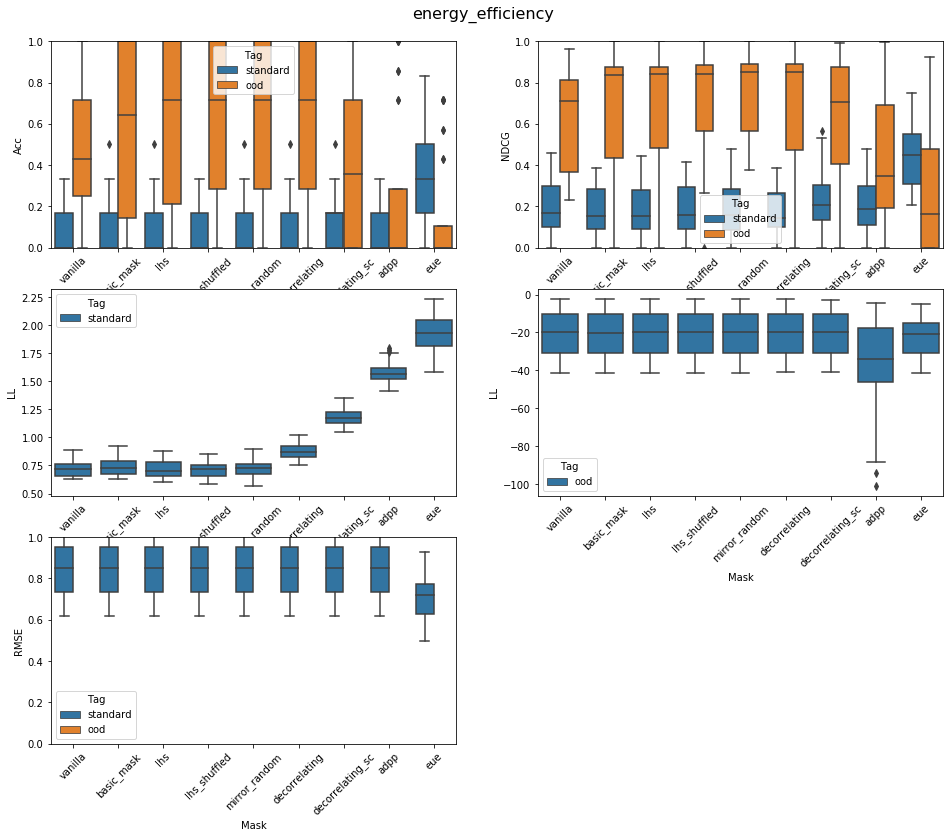

In [28]:
# # Plot the results
mask_df = pd.DataFrame(mask_results, columns=['Acc', 'NDCG', 'LL', 'RMSE', 'Mask', 'Tag'])

fig = plt.figure(figsize=(16, 16))
plt.suptitle(config['dataset'], fontsize=16)
fig.subplots_adjust(top=0.95)


def boxplot(df, x_label, y_label, i, bottom=0, top=1):
    plt.subplot(4, 2, i)
    plt.xticks(rotation=45)
    if bottom is not None:
        plt.ylim(bottom, top)
    sns.boxplot(data=df, x=x_label, y=y_label, hue='Tag')

boxplot(mask_df, 'Mask', 'Acc', 1, 0, 1)
boxplot(mask_df, 'Mask', 'NDCG', 2, 0, 1)
boxplot(mask_df[mask_df.Tag=='standard'], 'Mask', 'LL', 3, None)
boxplot(mask_df[mask_df.Tag=='ood'], 'Mask', 'LL', 4, None)
boxplot(mask_df, 'Mask', 'RMSE', 5, 0, None)

In [49]:
ensemble = MLPEnsemble(config['nll_layers'], n_models=5,
                    loss=NLLRegLoss, postprocessing=nll_postprocessing )
ensemble.fit((x_train, y_train), (x_val, y_val), **train_config)

Fit [0/5] model:
Epoch [100/10000], Loss: -0.9975, Validation loss: 2.4268
Epoch [200/10000], Loss: -1.1525, Validation loss: 2.5405
Epoch [300/10000], Loss: -1.3493, Validation loss: 7.7162
Epoch [400/10000], Loss: -2.0544, Validation loss: 810.3425
Fit [1/5] model:
Epoch [100/10000], Loss: -1.0749, Validation loss: 3.0670
Epoch [200/10000], Loss: -1.1341, Validation loss: 5.2999
Epoch [300/10000], Loss: -1.5203, Validation loss: 21.7030
Epoch [400/10000], Loss: -1.9001, Validation loss: 74.9063
Fit [2/5] model:
Epoch [100/10000], Loss: -0.3820, Validation loss: 0.2510
Epoch [200/10000], Loss: -0.9555, Validation loss: 3.6458
Epoch [300/10000], Loss: -1.3171, Validation loss: 18.8827
Epoch [400/10000], Loss: -1.7396, Validation loss: 26.6611
Fit [3/5] model:
Epoch [100/10000], Loss: -1.2092, Validation loss: 4.3214
Epoch [200/10000], Loss: -1.2943, Validation loss: 9.4444
Epoch [300/10000], Loss: -0.7428, Validation loss: 11.0185
Epoch [400/10000], Loss: -0.5726, Validation loss: 6.66

In [51]:
for m in ensemble.models:
    m.postprocessing = nll_mean_only
    
results = evaluate_ensemble(ensemble, x_val, y_val, y_scaler)
    

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [29]:
kfold_iterator = multiple_kfold(config['k_folds'], len(x_set), config['max_runs'])

for m, (train_idx, val_idx) in enumerate(kfold_iterator):
    x_train, y_train = x_set[train_idx], y_set[train_idx]
    x_val, y_val = x_set[val_idx], y_set[val_idx]
    print(" ------ Model {} -------".format(m+1))

    x_train, x_val, x_scaler = scale(x_train, x_val)
    y_train, y_val, y_scaler = scale(y_train, y_val)
    x_ood = x_scaler.transform(x_ood)
    y_ood = y_scaler.transform(y_ood)
    

    ensemble = MLPEnsemble(config['layers'], n_models=5)
    ensemble.fit((x_train, y_train), (x_val, y_val), **train_config)
    
    results = evaluate_ensemble(ensemble, x_val, y_val, y_scaler)
    mask_results.extend(results)
    results = evaluate_ensemble(ensemble, x_ood, y_ood, y_scaler, tag='ood')
    mask_results.extend(results)
    
    ensemble = MLPEnsemble(config['nll_layers'], n_models=5,
                    loss=NLLRegLoss, postprocessing=nll_postprocessing )
    ensemble.fit((x_train, y_train), (x_val, y_val), **train_config)
    
    for m in ensemble.models:
        m.postprocessing = nll_mean_only
    
    results = evaluate_ensemble(ensemble, x_val, y_val, y_scaler)
    mask_results.extend(results)
    results = evaluate_ensemble(ensemble, x_ood, y_ood, y_scaler, tag='ood')
    mask_results.extend(results)

 ------ Model 1 -------
Fit [0/5] model:
Epoch [100/10000], Loss: 0.0891, Validation loss: 0.3171
Epoch [200/10000], Loss: 0.0750, Validation loss: 0.2883
Epoch [300/10000], Loss: 0.0335, Validation loss: 0.2873
Epoch [400/10000], Loss: 0.0229, Validation loss: 0.2885
Epoch [500/10000], Loss: 0.0247, Validation loss: 0.3075
Epoch [600/10000], Loss: 0.0291, Validation loss: 0.3514
Fit [1/5] model:
Epoch [100/10000], Loss: 0.1546, Validation loss: 0.2755
Epoch [200/10000], Loss: 0.0356, Validation loss: 0.2780
Epoch [300/10000], Loss: 0.0247, Validation loss: 0.2873
Epoch [400/10000], Loss: 0.0168, Validation loss: 0.2733
Epoch [500/10000], Loss: 0.0269, Validation loss: 0.3048
Epoch [600/10000], Loss: 0.0080, Validation loss: 0.2929
Epoch [700/10000], Loss: 0.0172, Validation loss: 0.3036
Fit [2/5] model:
Epoch [100/10000], Loss: 0.1235, Validation loss: 0.2809
Epoch [200/10000], Loss: 0.0305, Validation loss: 0.2495
Epoch [300/10000], Loss: 0.0236, Validation loss: 0.2649
Epoch [400/10

RuntimeError: shape '[416]' is invalid for input of size 256

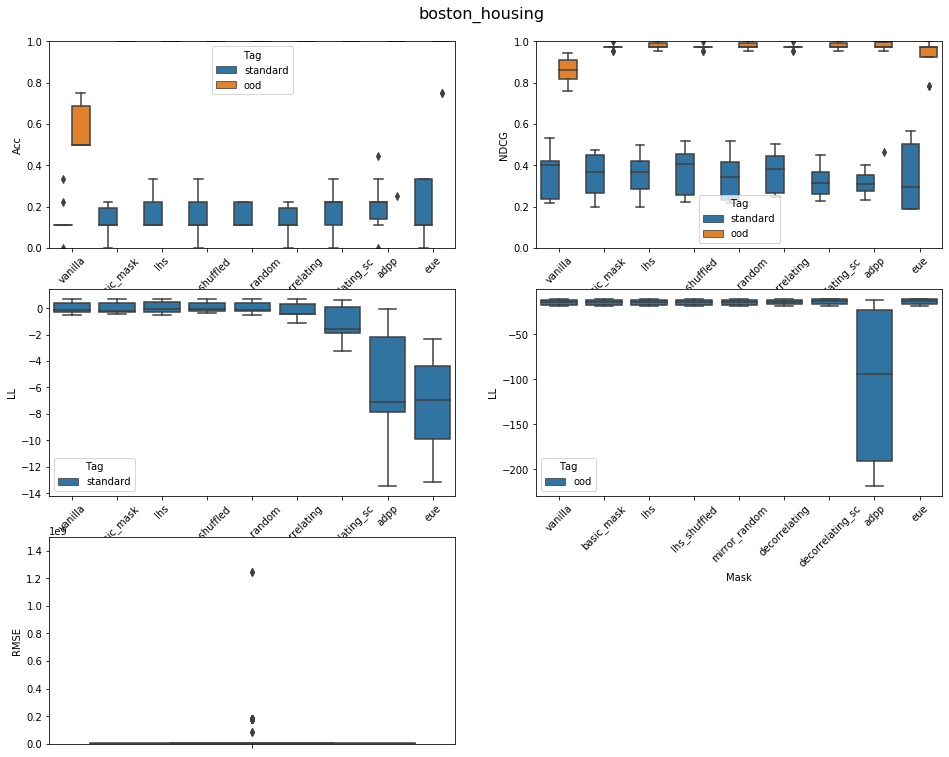

In [25]:
# # Plot the results
mask_df = pd.DataFrame(mask_results, columns=['Acc', 'NDCG', 'LL', 'RMSE', 'Mask', 'Tag'])

fig = plt.figure(figsize=(16, 16))
plt.suptitle(config['dataset'], fontsize=16)
fig.subplots_adjust(top=0.95)


def boxplot(df, x_label, y_label, i, bottom=0, top=1):
    plt.subplot(4, 2, i)
    plt.xticks(rotation=45)
    if bottom is not None:
        plt.ylim(bottom, top)
    sns.boxplot(data=df, x=x_label, y=y_label, hue='Tag')

boxplot(mask_df, 'Mask', 'Acc', 1, 0, 1)
boxplot(mask_df, 'Mask', 'NDCG', 2, 0, 1)
boxplot(mask_df[mask_df.Tag=='standard'], 'Mask', 'LL', 3, None)
boxplot(mask_df[mask_df.Tag=='ood'], 'Mask', 'LL', 4, None)
boxplot(mask_df, None, 'RMSE', 5, 0, 1.2*mask_df.RMSE.max())


In [ ]:
timestamp = datetime.now().strftime("%y-%m-%d__%H_%M")
with open(f"data/results_{config['dataset']}_{timestamp}.pkl", 'wb') as f:
    pickle.dump(mask_results, f)
    